#### Directories etc

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
import random
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import os
import copy
from Comparative_Analysis import ORF_Functions as orffn
from random import sample
import ete3;

C:\Users\nicho\Anaconda3\envs\Bioinformatics\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\nicho\Anaconda3\envs\Bioinformatics\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [49]:
project_dir = 'D:/Project_Data/Project_9'
cryptic_input_path = "F:/Datasets/CRYPTIC_DATA/"
seq_dir = 'D:/Project_Data/Project_8/Datasets/Actinobacteria_Ref_Rep_Lev_Complete'
tb_species = 'NC_000962.3' 
tb_genome_filename = 'GCF_000195955.2_ASM19595v2_genomic.gbff'
num_cores = 16
core_numbers = list(range(1, num_cores+1))
mycobrowser_dir = 'D:/Project_Data/Project_8/Datasets'

In [3]:
for record in SeqIO.parse(seq_dir + '/' + tb_genome_filename, "genbank"):
    full_sequence = str(record.seq)
for record in SeqIO.parse(project_dir + '/annot.gbk', "genbank"):
    reannotated_sequence = str(record.seq)

In [55]:
mycobrowser_features =[]
mycobrowser_df = pd.read_csv(mycobrowser_dir+'/Mycobrowser_Release_4.csv')
for i, r in mycobrowser_df.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    mycobrowser_features.append([r['Locus'],r['Start']-1, r['Stop'], strand])

In [4]:
barcode_df = pd.read_csv(project_dir +'/Barcode.csv')

In [5]:
full_run = False

#### Functions

In [6]:
def produce_sequences(position_list, variant_dict, position_dict):
    base_sequence = []
    for i in position_list:
        base_sequence.append(full_sequence[i-1])     # Cryptic are 1 based 
    output_sequence_dict ={}
    for k, v in variant_dict.items():
        output_sequence_dict[k] = copy.deepcopy(base_sequence)
    for i, pos in enumerate(position_list):
        if pos in position_dict:
            variant_info = position_dict[pos][1:]  # Miss out initlal "ref" record
            for (name, alt) in variant_info:
                output_sequence_dict[name][i] = alt.upper()
    output_sequences = []
    for k, v in output_sequence_dict.items():
        output_sequences.append(['seq_'+str(k), ''.join(v)])
    return output_sequences

In [7]:
def produce_sequences_to_score(position_list, variant_dict, position_dict, distinct_sequence_names):
    base_sequence = []
    for i in position_list:
        base_sequence.append({full_sequence[i-1]})     # Cryptic are 1 based 
    output_sequence_dict ={}
    for k, v in variant_dict.items():
        if k in distinct_sequence_names:
            output_sequence_dict[k] = copy.deepcopy(base_sequence)
    for i, pos in enumerate(position_list):
        if pos in position_dict:
            variant_info = position_dict[pos][1:]  # Miss out initlal "ref" record
            for (name, alt) in variant_info:
                if name in output_sequence_dict:
                    output_sequence_dict[name][i] = {alt.upper()}
    temp_dict = {}
    for k, v in output_sequence_dict.items():
        temp_dict['seq_'+str(k)] = v
    return temp_dict

In [8]:
def fitch_1(list_1, list_2):
    res =[]
    for i, j in zip(list_1, list_2):
        a = i.intersection(j)
        if len(a) == 0:
            a = i.union(j)
        res.append(a)
    return res

def fitch_2(parent_list, child_list):
    res = []
    mutations = []
    for i, j in zip(parent_list, child_list):
        mutation = 0
        a = i.intersection(j)
        if len(a) == 0:
            a = set(list(j)[0])
            mutation = 1
        res.append(a)
        if mutation == 1:
            mutations.append(1)
        else:
            mutations.append(0)
    return (res, mutations)

In [9]:
def bin_formula(position_3_counts, tot_bin_counts):
    return 1- binom.cdf(position_3_counts-1, tot_bin_counts,1/3)

In [10]:
def mutation_bin_probability(mutation_counts):
    bin_counts = [0,0,0]
    for i, c in enumerate(mutation_counts):
        bin_counts[i % 3] += c
    if sum(bin_counts) == 0:
        return (2)
    else:
        return (bin_counts, bin_formula(bin_counts[2], sum(bin_counts)))  

In [11]:
def calculation_mutation_significance(start, stop):  
    positions = list(range(start,stop))
    sequence_to_score_dict = produce_sequences_to_score(positions, variant_dict, position_dict, distinct_sequence_names)

    for node in master_tree.traverse("postorder"):
        if node.is_leaf():
            node.add_features(seq = sequence_to_score_dict[node.name])
        else:
            children = node.children
            node.add_features(seq = fitch_1(children[0].seq, children[1].seq))
    for k, v in sequence_to_score_dict.items():              
        seq_length = len(v)
        break

    mutation_counts = [0 for i in range(seq_length)]
    for node in master_tree.traverse("preorder"):
        if node.is_leaf():
            continue
        if node.is_root():
            node.seq = [{list(x)[0]} for x in node.seq]
        children = node.children
        mutations = []
        for child in children:
            (temp_1, temp_2) = fitch_2(node.seq ,child.seq)
            child.seq = temp_1
            mutations.append(temp_2)
        temp = []
        for h, i, j in zip(mutation_counts, mutations[0], mutations[1]):
            temp.append(h+max(i, j))
        mutation_counts = temp        
    return mutation_bin_probability(mutation_counts)

In [12]:
def generate_mutation_counts(filename):    
    a = filename.split('_')
    start = a[-3]
    stop = a[-2]
    with open(filename, 'rb') as f:
        sequence_to_score_dict = pickle.load(f)
    for node in master_tree.traverse("postorder"):
        if node.is_leaf():
            node.add_features(seq = sequence_to_score_dict[node.name])
        else:
            children = node.children
            node.add_features(seq = fitch_1(children[0].seq, children[1].seq))
    for k, v in sequence_to_score_dict.items():              
        seq_length = len(v)
        break

    mutation_counts = [0 for i in range(seq_length)]
    for node in master_tree.traverse("preorder"):
        if node.is_leaf():
            continue
        if node.is_root():
            node.seq = [{list(x)[0]} for x in node.seq]
        children = node.children
        mutations = []
        for child in children:
            (temp_1, temp_2) = fitch_2(node.seq ,child.seq)
            child.seq = temp_1
            mutations.append(temp_2)
        temp = []
        for h, i, j in zip(mutation_counts, mutations[0], mutations[1]):
            temp.append(h+max(i, j))
        mutation_counts = temp        
    return (start, stop, mutation_counts)

#### Create variant dictionaries 

In [ ]:
if full_run == True:
    variant_df = pd.read_csv(cryptic_input_path + "VARIANTS.csv") 
    with open(project_dir + '/variant_df.pkl', 'wb') as f:
        pickle.dump(variant_df[['UNIQUEID', 'VARIANT', 'MUTATION_TYPE', 'IS_NULL', 'IS_HET', 'IS_FILTER_PASS', 'IS_SNP', 'REF', 'ALT', 'GENOME_INDEX']], f)    

In [ ]:
if full_run == True:
    position_dict = {}
    variant_dict = {}
    id_dict = {}
    with open(project_dir + '/variant_df.pkl', 'rb') as f:
        variant_df = pickle.load(f) 
        unique_ids = variant_df.UNIQUEID.unique()
        for i, unique_id in enumerate(unique_ids):
            id_dict[unique_id] = i

        for i, r in variant_df.iterrows():
            if r['IS_NULL'] == False and r['IS_FILTER_PASS'] == True and r['IS_HET'] == False and r['IS_SNP'] == True :
                
                if id_dict[r['UNIQUEID']] in variant_dict:
                    variant_dict[id_dict[r['UNIQUEID']]].append((r['GENOME_INDEX'], r['ALT']))
                else:
                    variant_dict[id_dict[r['UNIQUEID']]] = [(r['GENOME_INDEX'], r['ALT'])]

                if r['GENOME_INDEX'] in position_dict:
                    position_dict[r['GENOME_INDEX']].append((id_dict[r['UNIQUEID']], r['ALT']))
                else:
                    position_dict[r['GENOME_INDEX']] = [r['REF'], (id_dict[r['UNIQUEID']], r['ALT'])]    # If first entry also include reference value for info

    with open(project_dir + '/id_dict.pkl', 'wb') as f:
        pickle.dump(id_dict, f)
    with open(project_dir + '/variant_dict.pkl', 'wb') as f:
        pickle.dump(variant_dict, f) 
    with open(project_dir + '/position_dict.pkl', 'wb') as f:
        pickle.dump(position_dict, f) 
        

In [59]:
if full_run == False:
    with open(project_dir + '/id_dict.pkl', 'rb') as f:
        id_dict = pickle.load(f)  
    with open(project_dir + '/variant_dict.pkl', 'rb') as f:
        variant_dict = pickle.load(f)  
    with open(project_dir + '/position_dict.pkl', 'rb') as f:
        position_dict = pickle.load(f)  

#### Output full sequences and distinct sequences based on barcode positions for construction of tree

In [60]:
barcode_snps = []
for i, r in barcode_df.iterrows():
    start = r['start'] + 1            # Cryptic file is 1 indexed
    lineage_name = r['lineage']
    if start in position_dict and 'lineage' in lineage_name:   # Just TB lineages
        barcode_snps.append(start)

In [63]:
len(barcode_snps)

985

In [61]:
sequences = produce_sequences(barcode_snps, variant_dict, position_dict)
util.produce_fasta_file(sequences, project_dir + '/' + 'tb_variants.faa')

100%|██████████| 77580/77580 [00:01<00:00, 72653.39it/s]


In [62]:
distinct_sequences = []
distinct_sequence_names = []
temp_dict = {}
for (ref, seq) in sequences:
    temp_dict[seq] = ref
for k, v in temp_dict.items():    
    distinct_sequences.append([v, k])
    distinct_sequence_names.append(int(v.split('_')[1]))
util.produce_fasta_file(distinct_sequences, project_dir + '/' + 'distinct_tb_variants.faa')

100%|██████████| 3045/3045 [00:00<00:00, 48240.62it/s]


In [ ]:
master_tree = ete3.Tree(project_dir + '/' + 'distinct_tb_variants.nwk')

#### Produce and save mutations per position (first produce files containing blocks of 10,000 nt values for all sequences in tree - will take about 36 hours)

In [ ]:
if full_run == True:
    small_variant_dict = {}
    for k, v in variant_dict.items():
        if k in distinct_sequence_names:
            small_variant_dict[k] = vtb_sequence_length = len(full_sequence)
    chunk_size = 10000
    num_chunks = math.ceil(tb_sequence_length/chunk_size)
    for chunk in tqdm(range(num_chunks)):
        start_pos = chunk * chunk_size
        end_pos = min(tb_sequence_length, start_pos + chunk_size)
        variant_sequence_dict = {}
        for k, v in small_variant_dict.items():
            temp = list(full_sequence)
            for (pos, snp) in v:
                temp[pos-1] = snp.upper()
            variant_sequence_dict['seq_'+str(k)] = [{x} for x in temp[start_pos:end_pos]]
        with open(project_dir + '/Cryptic_Sequence_Dictionaries/variant_dict_'+str(start_pos)+'_'+str(end_pos)+'_' + '.pkl', 'wb') as f:
                pickle.dump(variant_sequence_dict, f) 
                
    filename_list = util.list_files(project_dir+'/Cryptic_Sequence_Dictionaries')
    res = []
    start_time = time.time()
    for filename in tqdm(filename_list):
        temp = generate_mutation_counts(project_dir+'/Cryptic_Sequence_Dictionaries/'+filename)
        res.append(temp)
    with open(project_dir + '/mutation_counts.pkl', 'wb') as f:
                pickle.dump(res, f) 

In [13]:
if full_run == False:
    with open(project_dir + '/mutation_counts.pkl', 'rb') as f:
        mutation_counts = pickle.load(f)  
mutation_counts.sort(key = lambda x: int(x[0]))
mutation_count_list = []
for (start, stop, counts) in mutation_counts:
    for count in counts:
        mutation_count_list.append(count)

##### Calculate probabilites for Rv0001

In [14]:
cds_boundaries = []
for genome_record in SeqIO.parse(seq_dir + '/' + tb_genome_filename, "genbank"):
    for feature in genome_record.features:
        if feature.type == 'CDS':
            a = feature.qualifiers  
            if a.get("pseudo") == None:
                pseudo = False
            else:
                pseudo = True
            cds_boundaries.append((a.get("locus_tag")[0], pseudo, a.get("product")[0], int(feature.location.start), int(feature.location.end), int(feature.location.strand)))   
reannotated_cds_boundaries = []
for genome_record in SeqIO.parse(project_dir + '/annot.gbk', "genbank"):
    for feature in genome_record.features:
        if feature.type == 'CDS':
            a = feature.qualifiers  
            if a.get("pseudo") == None:
                pseudo = False
            else:
                pseudo = True
            reannotated_cds_boundaries.append((a.get("locus_tag")[0], pseudo, a.get("product")[0], int(feature.location.start), int(feature.location.end), int(feature.location.strand)))   
cds_boundaries.sort(key = lambda x: x[3])
reannotated_cds_boundaries.sort(key = lambda x: x[3])

In [65]:
temp =[]
for (locus, pseudo, product, start, stop, strand) in cds_boundaries:
    if pseudo == False:
        if strand == 1:
            temp.append(mutation_bin_probability(mutation_count_list[start:stop]))
        else:
            temp.append(mutation_bin_probability(reversed(mutation_count_list[start:stop])))
scores = []
for x in temp:
    if x == 2:
        scores.append(x)
    else:
        scores.append(x[1])

In [66]:
len([x for x in scores if x < 1e-2])

3009

In [67]:
len(scores)

3906

<AxesSubplot:ylabel='Count'>

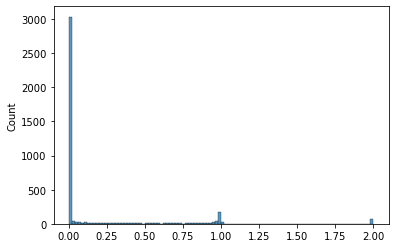

In [17]:
sns.histplot(scores, bins =100)

In [ ]:
for (locus, pseudo, product, start, stop, strand) in cds_boundaries:
    if strand == 1:
        prob = (mutation_bin_probability(mutation_count_list[start:stop]))
    else:
        prob = (mutation_bin_probability(reversed(mutation_count_list[start:stop])))
    overlap = 0
    for (loc, pse, pro, sta, sto, stra) in reannotated_cds_boundaries:
        if stop > sta and start < sto:
            a = (min(stop, sto) - max(sta, start)) / (stop - start)
            if a > 0.7:
                overlap = 1
                #print(locus, a, prob)
               
    if overlap == 0:
        print(locus, pseudo, start, stop, product, ' has no overlap', prob)

In [ ]:
for (locus, pseudo, product, start, stop, strand) in cds_boundaries:
    if strand == 1:
        prob = (mutation_bin_probability(mutation_count_list[start:stop]))
    else:
        prob = (mutation_bin_probability(reversed(mutation_count_list[start:stop])))
    print(locus, start, stop, strand, prob)

In [68]:
ORFFinder = orffn.ORF_Finder()

In [26]:
class Translator:
    def __init__(self):
        self.codon_dict = {}
        with open(os.path.join(sys.path[0], 'Standard_Code.txt'), 'r') as f:
        #with open('D:/Project_Data/Project_3/Datasets/Reference_Tables/Standard_Code.txt') as f:
            for l in f:
                self.codon_dict[str(l[1:4])] = l[5]
    
    def reverse_complement(self, seq_string):
        complement_dict = {'A':'T','C':'G','G':'C','T':'A','N':'N'}
        temp = []
        for char in reversed(seq_string):
            temp.append(complement_dict[char])
        return ''.join(temp)
    
    def translate_sequence(self, input_seq, strand, rf, separate_start_symbol = False, separate_stop_symbol = False):
        output_seq = ''
        if strand == 1:
            seq = input_seq[rf:]
        else:
            seq = self.reverse_complement(input_seq)[rf:]
        for i in range(0,len(seq)-2,3):
            if separate_start_symbol == True and seq[i:(i+3)] in ['ATG','GTG','TTG']:
                output_seq += 'Z'
            elif separate_stop_symbol == True and seq[i:(i+3)] in ['TAG','TGA','TAA']:
                output_seq += 'J'

In [80]:
min_intergenic_length = 300
details =  []
for i, (locus, pseudo, product, start, stop, strand) in enumerate(cds_boundaries):
    if i < len(cds_boundaries) - 1:
        if cds_boundaries[i+1][3] > stop + min_intergenic_length:
            a =ORFFinder.max_orf(stop-40, cds_boundaries[i+1][3]+40, 5, output_all_orfs = False, min_orf_length = 300)
            if a == (0,0,0):
                pass
            else:
                details.append(a[3])

In [82]:
len(details)

149

<AxesSubplot:ylabel='Count'>

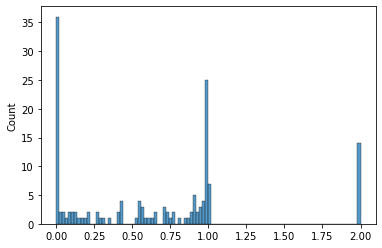

In [81]:
sns.histplot(details, bins=100)

In [98]:
trans = util.Translator()
min_intergenic_length = 400
details =  []
results =[]
for i, (locus, pseudo, product, start, stop, strand) in enumerate(cds_boundaries):
    if i < len(cds_boundaries) - 1:
        if cds_boundaries[i+1][3] > stop + min_intergenic_length:
            a =ORFFinder.max_orf(stop-40, cds_boundaries[i+1][3]+40, 1e-3, output_all_orfs = False, min_orf_length = 300)
            if not(a==(0,0,0)):
                ov = 0
                info = ('','','','','','','')
                for i, (loc, pse, pro, sta, sto, stra) in enumerate(reannotated_cds_boundaries):
                    if a[1] > sta and a[0] < sto:
                        ov = (min(a[1], sto) - max(a[0], sta)) / (sto - sta)
                        if ov > 0.3:
                            info =  (loc, pse, pro, sta, sto, stra, ov)
                        
                ov = 0
                myco_info = ('','','','','')
                for i, (loc, sta, sto, stra) in enumerate(mycobrowser_features):
                    if a[1] > sta and a[0] < sto:
                        ov = (min(a[1], sto) - max(a[0], sta)) / (sto - sta)
                        if ov > 0.3:
                            myco_info =  (loc, sta, sto, stra, ov)
                        
                sequ = trans.translate_sequence(full_sequence[a[0]:a[1]], a[2], 0)
                details.append([a, sequ])
                print(a)
                print(sequ)
                #print(info)
                #print(myco_info)
                print("")
                results.append([a[0],a[1],a[2],a[3],info[0],info[1],info[2],info[3],info[4],info[5],info[6],myco_info[0],myco_info[1],myco_info[2],myco_info[3],myco_info[4]])
results_df = pd.DataFrame(results, columns = ['start_pos','end_pos','strand','score','PGAP_ref','PGAP_pseudogene','PGAP_product', 'PGAP_start', 'PGAP_end','PGAP_strand', 'PGAP_overlap', 'Mycob_ref','Mycob_start', 'Mycob_end','Mycob_strand', 'Mycob_overlap'])
results_df.to_csv(project_dir + '/cds_candidates.csv')

(257782, 258904, -1, 0.0)
MLAGYRTGGQYGGRQKVRNELNDDEAMLVATVRAFIDRDVKPTVREVEHANSYPEAWIEQMKHIGIYGLAIDEQYGGSPVSMPCYVQVTQELARGWMSLAGAMGGHTVVAKLLTLFGTEEQRRTYLPPMASGELRATMALTEPGGGSDLQNMSTTALADGPEGSAGLLINGCKTWISNARRSGLFAVLCKTDPNATPRHQGMSIVLVEPGPGLTVSRDLPKLGYKGVESCELSFDNLRVPVSAILGGAMGQGFSQMMKGLETGRIQVAARALGVATAALEDSLAYAQQRESFGRPIWQHQAVGNYLADMATKLTAARQLTRYAAERYDSGQRCDMEAGMAKLFASEVAMEIALNAVRIHGGYGYSTEYDVERR*

(467458, 468001, -1, 0.0)
MDFGALPPEINSARIYSGPGSRPLMQAAAAWQRLANELTATAASYSSVISGLTGDDWLGPSALSMAAAAVPYVAWMRATAASAEQAAAQAVAAANAYESAYAATVPPTVIAANRRTMLSLVQTNVFGQNTPAIATSETHYGEMWAHDILAMDGYAGASGAASQLRRSPATGDHQRGRVAE*

(711535, 712231, 1, 0.0)
MSATPPPGGLDASVFIANERGRQLDEALPVGFCVVTAPTRWTLADGRDLLFFSLPGHVPAPVSDRRPLPERDPAPSRLRFDRATGQWVIVAAQRQDRTYKPPAARCPLCPGPTGLSSEVPAPDYDVVVFENRFPSLAGAGIAPIGAPDGDGFVSAPGHGRCEVICFSADHTGSFAGLDPAHARLVVHAWRHRTAELTALPGVAQVFCFENRGEEIGVTLPTRTARFTPIRI*

(874731, 876390, 1, 0.0)
VTNDIPCGSRIYAPENSTRTRSPGSERESPGQLTTTVYYTTVDAAWRPDTVWRYRLGSGESSERVYHEADDRFWLAVGRTRSNAYLLIAAGSSITSEVRYAHAAD

In [54]:
mycobrowser_features

[['Rv3924c', 4410785, 4410929, -1]]

In [ ]:
mutation_bin_probability(reversed(mutation_count_list[13132:13558]))

In [97]:
for i in reannotated_cds_boundaries:
    if i[0] == "tmp_002459":
        print(i)

('tmp_002459', False, 'aminotransferase class III-fold pyridoxal phosphate-dependent enzyme', 2594698, 2595364, -1)


#### Legacy code (might be useful - this is when tree was defined based on "optimal splits")

In [ ]:
def split_tree(species_to_split, position):
    temp = fast_position_dict[position].intersection(species_to_split)
    temp_2 = species_to_split - temp
    if len(temp_2) > 1 and len(temp) > 1:
        return ([(position, temp, len(temp)), (position, temp_2, len(temp_2))])
    else:
        return([(-1, species_to_split, len(species_to_split))])

In [ ]:
def optimal_split_position(species_to_split_list):
    best_split_num = 1e20
    best_position = 0
    #for k in barcode_snps:
    for k, v in fast_position_dict.items():
        #v = fast_position_dict[k]
        mutation_count = 0
        for species_to_split in species_to_split_list:
            num_species_to_split = len(species_to_split)
            optimal_split = int(num_species_to_split/2)
            mutation_count += abs(len(v.intersection(species_to_split)) - optimal_split)
       
        if abs(mutation_count) < abs(best_split_num):
            best_position = k
            best_split_num = abs(mutation_count)
          
    return(best_position, best_split_num)

In [ ]:
all_species = [[-1,set(x for x in range(len(id_dict))),99,True]]
pos = optimal_split_position([x[1] for x in all_species])[0]
split_results = [split_tree(all_species[0][1], pos)]
print( [(x[0], x[2]) for x in split_results[0]] )
for i in range(1,10):
    start = time.process_time()
    split_results.append([])
    posn = optimal_split_position([x[1] for x in split_results[i-1]])
    pos= posn[0]
    split_score = posn[1]
    successful_splits = 0
    for x in split_results[i-1]:
        temp = split_tree(x[1], pos) 
        if len(temp) == 1:
            split_results[i].append(temp[0])
        else:
            successful_splits +=1
            split_results[i].append(temp[0])
            split_results[i].append(temp[1])
    print(max([x[2] for x in split_results[i]]), [(x[0], x[2]) for x in split_results[i]] )
    if successful_splits == 0:
        break

In [ ]:
temp = []
for res in split_results:
    for info in res:
        temp.append(info[0])
snps = set(temp)
snps.remove(-1)

In [ ]:
def consensus(seq_list):
    consensus = []
    seq_len = len(seq_list[0])
    for i in range(seq_len):
        temp = [x[i] for x in seq_list]
        max_count = 0
        consensus_letter = 'X'
        for letter in ['A', 'C' ,'G', 'T']:
            tempct = temp.count(letter)
            if tempct > max_count:
                max_count = tempct
                consensus_letter = letter
        consensus.append(consensus_letter)
    return ''.join(consensus)